In [1]:
import pandas as pd

### 전처리

In [14]:
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter
import regex
import re

from nltk.tokenize import TreebankWordTokenizer

from flashtext import KeywordProcessor
kp = KeywordProcessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brightcircle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import spacy

nlp = spacy.load("en_core_web_sm")


In [46]:
spacy_stopwords = nlp.Defaults.stop_words
print(len(spacy_stopwords))
print(type(spacy_stopwords))


326
<class 'set'>


In [48]:
class Preprocessing :
    """
    sumary
    """
    
    def __init__(self, df ) :
        self.df = df
        self.nlp = spacy.load("en_core_web_sm")
        self.spacy_stopwords = nlp.Defaults.stop_words
        self.stopwords_list = list(spacy_stopwords) #불용어 리스트
        self.synonym_dict = {"n't" : ['not']} # 동의어 딕셔너리
    
    def only_eng(self, df) :
        list_par = []
        for i in df.index :
            for idx in df['token'][i] :

                text = re.sub('[^a-zA-Z0-9]', '', idx).strip() #숫자와 영어만
                text = text.lower()
                if(text!=''):
                    list_par.append(text)


    """ def lemmatizer(text):
        spacy.prefer_gpu()
        nlp = spacy.load("en_core_web_sm")        
        sent = []
        doc = nlp(text)
        for word in doc:
            sent.append(word.lemma_)
        return " ".join(sent) """

    def lemmatize(self, words=[]) :
        spacy.prefer_gpu()
        nlp = spacy.load("en_core_web_sm")
        self.df['token'] =0 
        self.df['token'] = self.df["review"].progress_apply(lambda row: [w.lemma_ for w in nlp(row)])

        self.stopwords_list.extend(words)
        self.df['token'] = self.df['token'].progress_map(lambda x:[w for w in x if not w in self.stopwords_list])

        for idx in tqdm(self.df.index) :
            
            #self.df['token'][idx] = lemmatizer(self.df['review'][idx])
            list_par = []
            for i in self.df['token'][idx] :
                text = re.sub('[^a-zA-Z0-9]', '', i).strip()
                text = text.lower()
                if(text!='' and len(text)>1): #2 글자 이상의 단어만 포함
                    list_par.append(text) 


            self.df['token'][idx] = list_par
    
        print(self.df['token'])

        
        
    def tokenize(self) :
        tokenizer = TreebankWordTokenizer()
        self.df['token'] =0 
        
        for idx in tqdm(self.df.index) :
            self.df['token'][idx] = tokenizer.tokenize(self.df['text'][idx])
            
            list_par = []
            for i in self.df['token'][idx] :
                text = re.sub('[^a-zA-Z]', '', i).strip()
                text = text.lower()
                if(text!='' and len(text)>1): #2 글자 이상의 단어만 포함
                    list_par.append(text)


            self.df['token'][idx] = list_par
    
        print(self.df['token'])

    
    def elim_stopwords(self, words=[]):
        self.stopwords_list.extend(words)
        self.df['token'] = self.df['token'].map(lambda x:[w for w in x if not w in self.stopwords_list]) 
        
    def synonym(self) :
        kp.add_keywords_from_dict(self.synonym_dict)
        df['token'] = [[kp.replace_keywords(x) for x in w] for w in tqdm(df['token'])]

### DMR

In [11]:

import tomotopy as tp
print(tp.isa)
import sys
import numpy as np
import logging

sse2


In [10]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
import matplotlib.colors as clr
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [177]:
import seaborn as sns


def dmr_plot2(mdl):
    meta_dict = mdl.metadata_dict # 메타 데이터 종류 1개
    meta_k_arr = np.zeros((len(meta_dict), mdl.k))

    for i in range(len(meta_dict)):
        meta_k_arr[i, :] = np.exp(mdl.lambdas)[:, i] / np.exp(mdl.lambdas)[:, i].sum()

    viz_df = pd.DataFrame(meta_k_arr, columns=['Topic #{}'.format(k) for k in range(mdl.k)], index=meta_dict)
    fig1 = plt.figure(figsize=(15, 8))
    ax = plt.gca()
    assert plt.gcf() is fig1  # succeeds
    viz_df.sort_index(ascending=False).plot(kind='barh', stacked=True,
                                            colormap=ListedColormap(sns.color_palette("Set3", 54)),
                                            ax=ax)  # draws to fig1 now

    #sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [69]:
def DMR(df) :
    global token_rate_dict
    DMR_rate = tp.DMRModel(k=10,min_df=100,tw=tp.TermWeight.IDF, alpha = 0.01, seed=2021, rm_top=10)
    token_rate_dict = df[['token','colony label']].to_dict('index')

    for k in tqdm(token_rate_dict.keys()):
        DMR_rate.add_doc(token_rate_dict[k]['token'], str(token_rate_dict[k]['colony label']))

    DMR_rate.train(0)

    print('Num docs:', len(DMR_rate.docs), ', Vocab size:', DMR_rate.num_vocabs, ', Num words:', DMR_rate.num_words)
    print('Removed top words:', DMR_rate.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    for i in range(0, 500, 20):
        DMR_rate.train(20)
        print('Iteration: {}\tLog-likelihood: {}'.format(i, DMR_rate.ll_per_word))


    print('--------------------------------------------------------------------------')


    DMR_rate.summary()
    
    print('--------------------------------------------------------------------------')

    for i in range(DMR_rate.k):
        res = DMR_rate.get_topic_words(i, top_n=20)
        print('Topic #{}'.format(i), end='\t')
        print(', '.join(w for w, p in res))
    

    dmr_plot2(DMR_rate)

    return DMR_rate

### LEXIS

In [88]:
df_lex = pd.read_csv('./Museum_afterparsing.csv')
df_lex

,ID,Source_File,Newspaper,Date,Length,Section,Author,Edition,Headline,Graphic,Article
0,1,C:/Users/Haein/Desktop/Museum/20140601~2016090...,Los Angeles Times,2015-06-26,642 words,CALIFORNIA; Metro Desk; Part B; Pg. 3,Stephen Ceasar,NaN,LOS ANGELES; Legal battle over massive emerald...,False,The more than six-year legal battle over the B...
1,2,C:/Users/Haein/Desktop/Museum/20140601~2016090...,The Guardian,2015-06-26,1934 words,TECHNOLOGY,Keith Stuart,NaN,Hearthstone: how a game developer turned 30m p...,False,On the set of ITV's costume drama Mr Selfridge...
2,3,C:/Users/Haein/Desktop/Museum/20140601~2016090...,The Guardian,2015-06-26,628 words,TELEVISION & RADIO,Maraithe Thomas in New York,NaN,My afternoon at the Seinfeld apartment; A new ...,False,Related: Seinfeld on Hulu: which episodes sho...
3,4,C:/Users/Haein/Desktop/Museum/20140601~2016090...,Jerusalem Post,2015-06-26,1152 words,FEATURES; Pg. 26,MEITAL SHARABI,NaN,Tiberias: Israel's diamond in the rough,False,The Kinneret is one of the most beautiful spot...
4,5,C:/Users/Haein/Desktop/Museum/20140601~2016090...,Los Angeles Times,2015-06-26,1128 words,MAIN NEWS; Letters Desk; Part A; Pg. 18,NaN,NaN,LETTERS,False,"He's served L.A. well Re ""Patt Morrison Asks: ..."
...,...,...,...,...,...,...,...,...,...,...,...
24769,173,C:/Users/Haein/Desktop/Museum/20220613~2022070...,Newsday (New York),2022-06-17,503 words,NEWS; Pg. 34,The Washington Post,NaN,"NATION; Harry Gesner, 97, California architect...",False,"The Washington Post To design a great house, C..."
24770,174,C:/Users/Haein/Desktop/Museum/20220613~2022070...,The Philadelphia Inquirer,2022-06-17,1371 words,THE REGION; Pg. B1,Valerie Russ STAFF WRITER,NaN,Norristown exhibit honors historian Charles Bl...,False,ABSTRACT His life's work was fueled by a fourt...
24771,175,C:/Users/Haein/Desktop/Museum/20220613~2022070...,mirror.co.uk,2022-06-17,1180 words,TRAVEL; Version:1,"By, Nigel Thompson",NaN,Take a shine to golden wonders from around the...,False,All that glisters is not gold - Often have ...
24772,176,C:/Users/Haein/Desktop/Museum/20220613~2022070...,The Philadelphia Inquirer,2022-06-17,1710 words,SPORTS; Pg. D1,Mike Jensen STAFF WRITER,NaN,She helped change the game; Former Owls badmin...,False,ABSTRACT Former Owls badminton player was lead...


In [92]:
df_lex.columns

Index(['ID', 'Source_File', 'Newspaper', 'Date', 'Length', 'Section', 'Author',
       'Edition', 'Headline', 'Graphic', 'Article'],
      dtype='object')

In [94]:
df_lex = df_lex[['Newspaper', 'Date', 'Length', 'Author', 'Headline', 'Article']]
df_lex

,Newspaper,Date,Length,Author,Headline,Article
0,Los Angeles Times,2015-06-26,642 words,Stephen Ceasar,LOS ANGELES; Legal battle over massive emerald...,The more than six-year legal battle over the B...
1,The Guardian,2015-06-26,1934 words,Keith Stuart,Hearthstone: how a game developer turned 30m p...,On the set of ITV's costume drama Mr Selfridge...
2,The Guardian,2015-06-26,628 words,Maraithe Thomas in New York,My afternoon at the Seinfeld apartment; A new ...,Related: Seinfeld on Hulu: which episodes sho...
3,Jerusalem Post,2015-06-26,1152 words,MEITAL SHARABI,Tiberias: Israel's diamond in the rough,The Kinneret is one of the most beautiful spot...
4,Los Angeles Times,2015-06-26,1128 words,NaN,LETTERS,"He's served L.A. well Re ""Patt Morrison Asks: ..."
...,...,...,...,...,...,...
24769,Newsday (New York),2022-06-17,503 words,The Washington Post,"NATION; Harry Gesner, 97, California architect...","The Washington Post To design a great house, C..."
24770,The Philadelphia Inquirer,2022-06-17,1371 words,Valerie Russ STAFF WRITER,Norristown exhibit honors historian Charles Bl...,ABSTRACT His life's work was fueled by a fourt...
24771,mirror.co.uk,2022-06-17,1180 words,"By, Nigel Thompson",Take a shine to golden wonders from around the...,All that glisters is not gold - Often have ...
24772,The Philadelphia Inquirer,2022-06-17,1710 words,Mike Jensen STAFF WRITER,She helped change the game; Former Owls badmin...,ABSTRACT Former Owls badminton player was lead...


In [89]:
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter
import regex
import re

from nltk.tokenize import TreebankWordTokenizer

from flashtext import KeywordProcessor
kp = KeywordProcessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brightcircle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
import spacy

nlp = spacy.load("en_core_web_sm")


In [91]:
spacy_stopwords = nlp.Defaults.stop_words
print(len(spacy_stopwords))
print(type(spacy_stopwords))


326
<class 'set'>


In [96]:
class Preprocessing_lex :
    """
    sumary
    """
    
    def __init__(self, df ) :
        self.df = df
        self.nlp = spacy.load("en_core_web_sm")
        self.spacy_stopwords = nlp.Defaults.stop_words
        self.stopwords_list = list(spacy_stopwords) #불용어 리스트
        self.synonym_dict = {"n't" : ['not']} # 동의어 딕셔너리
    
    def only_eng(self, df) :
        list_par = []
        for i in df.index :
            for idx in df['token'][i] :

                text = re.sub('[^a-zA-Z0-9]', '', idx).strip() #숫자와 영어만
                text = text.lower()
                if(text!=''):
                    list_par.append(text)


    """ def lemmatizer(text):
        spacy.prefer_gpu()
        nlp = spacy.load("en_core_web_sm")        
        sent = []
        doc = nlp(text)
        for word in doc:
            sent.append(word.lemma_)
        return " ".join(sent) """

    def lemmatize(self, words=[]) :
        spacy.prefer_gpu()
        nlp = spacy.load("en_core_web_sm")
        self.df['token'] =0 
        self.df['token'] = self.df["Article"].progress_apply(lambda row: [w.lemma_ for w in nlp(row)])

        self.stopwords_list.extend(words)
        self.df['token'] = self.df['token'].progress_map(lambda x:[w for w in x if not w in self.stopwords_list])

        for idx in tqdm(self.df.index) :
            
            #self.df['token'][idx] = lemmatizer(self.df['review'][idx])
            list_par = []
            for i in self.df['token'][idx] :
                text = re.sub('[^a-zA-Z0-9]', '', i).strip()
                text = text.lower()
                if(text!='' and len(text)>1): #2 글자 이상의 단어만 포함
                    list_par.append(text) 


            self.df['token'][idx] = list_par
    
        print(self.df['token'])

        
        
    def tokenize(self) :
        tokenizer = TreebankWordTokenizer()
        self.df['token'] =0 
        
        for idx in tqdm(self.df.index) :
            self.df['token'][idx] = tokenizer.tokenize(self.df['text'][idx])
            
            list_par = []
            for i in self.df['token'][idx] :
                text = re.sub('[^a-zA-Z]', '', i).strip()
                text = text.lower()
                if(text!='' and len(text)>1): #2 글자 이상의 단어만 포함
                    list_par.append(text)


            self.df['token'][idx] = list_par
    
        print(self.df['token'])

    
    def elim_stopwords(self, words=[]):
        self.stopwords_list.extend(words)
        self.df['token'] = self.df['token'].map(lambda x:[w for w in x if not w in self.stopwords_list]) 
        
    def synonym(self) :
        kp.add_keywords_from_dict(self.synonym_dict)
        df['token'] = [[kp.replace_keywords(x) for x in w] for w in tqdm(df['token'])]

In [97]:
preprecess_lex=Preprocessing_lex(df_lex)

preprecess_lex.lemmatize()

/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/4052389075.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['token'] =0


  0%|          | 0/24774 [00:00<?, ?it/s]

/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/4052389075.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['token'] = self.df["Article"].progress_apply(lambda row: [w.lemma_ for w in nlp(row)])


  0%|          | 0/24774 [00:00<?, ?it/s]

/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/4052389075.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['token'] = self.df['token'].progress_map(lambda x:[w for w in x if not w in self.stopwords_list])


  0%|          | 0/24774 [00:00<?, ?it/s]

/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/4052389075.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['token'][idx] = list_par


0        [year, legal, battle, bahia, emerald, reach, c...
1        [set, itv, costume, drama, mr, selfridge, quie...
2        [relate, seinfeld, hulu, episode, download, tu...
3        [kinneret, beautiful, spot, country, reason, p...
4        [serve, la, patt, morrison, ask, tom, labonge,...
                               ...                        
24769    [washington, post, design, great, house, calif...
24770    [abstract, life, work, fuel, fourth, grade, te...
24771    [glister, gold, hear, tell, students, william,...
24772    [abstract, owls, badminton, player, lead, plai...
24773    [tuesday, friday, ezra, klein, invite, convers...
Name: token, Length: 24774, dtype: object


In [98]:
df_lex.to_pickle('대용박물관_article_전처리 완료.pickle')

In [99]:
df_lex

,Newspaper,Date,Length,Author,Headline,Article,token
0,Los Angeles Times,2015-06-26,642 words,Stephen Ceasar,LOS ANGELES; Legal battle over massive emerald...,The more than six-year legal battle over the B...,"[year, legal, battle, bahia, emerald, reach, c..."
1,The Guardian,2015-06-26,1934 words,Keith Stuart,Hearthstone: how a game developer turned 30m p...,On the set of ITV's costume drama Mr Selfridge...,"[set, itv, costume, drama, mr, selfridge, quie..."
2,The Guardian,2015-06-26,628 words,Maraithe Thomas in New York,My afternoon at the Seinfeld apartment; A new ...,Related: Seinfeld on Hulu: which episodes sho...,"[relate, seinfeld, hulu, episode, download, tu..."
3,Jerusalem Post,2015-06-26,1152 words,MEITAL SHARABI,Tiberias: Israel's diamond in the rough,The Kinneret is one of the most beautiful spot...,"[kinneret, beautiful, spot, country, reason, p..."
4,Los Angeles Times,2015-06-26,1128 words,NaN,LETTERS,"He's served L.A. well Re ""Patt Morrison Asks: ...","[serve, la, patt, morrison, ask, tom, labonge,..."
...,...,...,...,...,...,...,...
24769,Newsday (New York),2022-06-17,503 words,The Washington Post,"NATION; Harry Gesner, 97, California architect...","The Washington Post To design a great house, C...","[washington, post, design, great, house, calif..."
24770,The Philadelphia Inquirer,2022-06-17,1371 words,Valerie Russ STAFF WRITER,Norristown exhibit honors historian Charles Bl...,ABSTRACT His life's work was fueled by a fourt...,"[abstract, life, work, fuel, fourth, grade, te..."
24771,mirror.co.uk,2022-06-17,1180 words,"By, Nigel Thompson",Take a shine to golden wonders from around the...,All that glisters is not gold - Often have ...,"[glister, gold, hear, tell, students, william,..."
24772,The Philadelphia Inquirer,2022-06-17,1710 words,Mike Jensen STAFF WRITER,She helped change the game; Former Owls badmin...,ABSTRACT Former Owls badminton player was lead...,"[abstract, owls, badminton, player, lead, plai..."


In [101]:
len(df_lex['Newspaper'].unique())

83

### LDA

In [106]:
class TopicModeling :
    
    def __init__(self, df, k, min_df=5 ) : #df = 데이터, k은 토픽 개수, min_df =10
        self.df = df
        self.k = k
        self.min_df= min_df
    
            
    def LDA(self) :
        
        LDA_model = tp.LDAModel(k= self.k, min_df=self.min_df, tw= tp.TermWeight.IDF, rm_top=0, alpha=0.1, eta= 0.01, seed=2022 )
        for token in self.df['token'].tolist():
            LDA_model.add_doc(token)

        return LDA_model
       
        
    def train(self, LDA_model) :
        LDA_model.train(0)
        print('Num docs:', len(LDA_model.docs), ', Vocab size:', LDA_model.num_vocabs, ', Num words:', LDA_model.num_words)
        print('Removed top words:', LDA_model.removed_top_words) #확인
        print('Training...', file=sys.stderr, flush=True)
        for i in range(0, 500, 100):
            LDA_model.train(100)
            print('Iteration: {}\tLog-likelihood: {}'.format(i, LDA_model.ll_per_word))
            
    def get_coherence(self, LDA_model) :
        coherence = tp.coherence
        score = coherence.Coherence(LDA_model).get_score()
        perplexity = LDA_model.perplexity
        print('topic 개수 : ', self.k , '| 사용된 vocab 수 : ',len(LDA_model.used_vocabs) ,'| Coherence 점수 : ', score, '| Perplexity 점수 : ', np.log(perplexity))
    

        return score, perplexity

In [107]:
lda = TopicModeling(df_lex,54)
model = lda.LDA()
lda.train(model)
lda.get_coherence(model)
len(model.used_vocabs)

Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.808848036829854
Iteration: 100	Log-likelihood: -9.66068401019232
Iteration: 200	Log-likelihood: -9.593158436987629
Iteration: 300	Log-likelihood: -9.555355871125764
Iteration: 400	Log-likelihood: -9.531195264183964
topic 개수 :  54 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.467086038120505 | Perplexity 점수 :  9.531195264183964


63062

In [108]:
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10) # top 10
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))
    

Topic #0	bp, company, oil, million, fund, business, money, bank, tax, economic
Topic #1	theatre, opera, ballet, dance, 020, theater, dancer, london, festival, production
Topic #2	novel, awards, actress, book, comedy, literature, drama, fiction, actors, writers
Topic #3	zealand, napoleon, italy, london, vienna, de, wellington, auckland, france, queen
Topic #4	bst, gmt, block, brexit, johnson, eu, labour, minister, uk, timeupdated
Topic #5	black, slavery, african, slave, racism, civil, confederate, law, court, negative
Topic #6	father, university, college, school, die, death, mother, student, mr, family
Topic #7	baseball, game, sports, player, league, team, sport, football, fame, hall
Topic #8	pm, 212, street, am, saturday, sunday, avenue, brooklyn, friday, 718
Topic #9	feel, think, like, thing, want, way, people, look, tell, kind
Topic #10	bauhaus, annabelle, roth, snowden, conjuring, vera, farmiga, doll, warren, kenosha
Topic #11	greece, greek, british, sculpture, athens, elgin, parthe

Number of unique tokens: 63062
Number of documents: 24774


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.943683668319254
Iteration: 100	Log-likelihood: -9.931252967213453
Iteration: 200	Log-likelihood: -9.92417916836017
Iteration: 300	Log-likelihood: -9.920437683826412
Iteration: 400	Log-likelihood: -9.918338774650202
topic 개수 :  2 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.1059921237424133 | Perplexity 점수 :  9.918338774650202


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -10.024958929412353
Iteration: 100	Log-likelihood: -9.961969020573429
Iteration: 200	Log-likelihood: -9.933905004554063
Iteration: 300	Log-likelihood: -9.91854985034451
Iteration: 400	Log-likelihood: -9.910262643278179
topic 개수 :  6 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.4196458380786512 | Perplexity 점수 :  9.910262643278179


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -10.036810184807662
Iteration: 100	Log-likelihood: -9.955125165751909
Iteration: 200	Log-likelihood: -9.916738720512164
Iteration: 300	Log-likelihood: -9.893356713542035
Iteration: 400	Log-likelihood: -9.87931680076398
topic 개수 :  10 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.5983953211815236 | Perplexity 점수 :  9.87931680076398


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.987963821302513
Iteration: 100	Log-likelihood: -9.914858845080525
Iteration: 200	Log-likelihood: -9.879159994212547
Iteration: 300	Log-likelihood: -9.859656057011465
Iteration: 400	Log-likelihood: -9.844842154298451
topic 개수 :  14 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.7723308606513342 | Perplexity 점수 :  9.844842154298451


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.967657929515635
Iteration: 100	Log-likelihood: -9.879474667345576
Iteration: 200	Log-likelihood: -9.838510770127371
Iteration: 300	Log-likelihood: -9.814763735072933
Iteration: 400	Log-likelihood: -9.799800266640789
topic 개수 :  18 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.9592127350351451 | Perplexity 점수 :  9.799800266640789


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.939577289373787
Iteration: 100	Log-likelihood: -9.828330926356681
Iteration: 200	Log-likelihood: -9.777901071973591
Iteration: 300	Log-likelihood: -9.752049903562437
Iteration: 400	Log-likelihood: -9.735613948735605
topic 개수 :  22 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.5175617067102634 | Perplexity 점수 :  9.735613948735605


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.922800037507534
Iteration: 100	Log-likelihood: -9.808221749610237
Iteration: 200	Log-likelihood: -9.7569715567301
Iteration: 300	Log-likelihood: -9.727006204828118
Iteration: 400	Log-likelihood: -9.706697316359836
topic 개수 :  26 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.7625830890705187 | Perplexity 점수 :  9.706697316359836


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.921798108210448
Iteration: 100	Log-likelihood: -9.803299403301093
Iteration: 200	Log-likelihood: -9.749448986626192
Iteration: 300	Log-likelihood: -9.717581798351928
Iteration: 400	Log-likelihood: -9.697348471594895
topic 개수 :  30 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.8225250217687856 | Perplexity 점수 :  9.697348471594895


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.902147175530603
Iteration: 100	Log-likelihood: -9.776844100976998
Iteration: 200	Log-likelihood: -9.720303894528595
Iteration: 300	Log-likelihood: -9.68815743103731
Iteration: 400	Log-likelihood: -9.668393599140831
topic 개수 :  34 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.4372990780925665 | Perplexity 점수 :  9.668393599140831


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.862642570748827
Iteration: 100	Log-likelihood: -9.734862525817979
Iteration: 200	Log-likelihood: -9.67846063673563
Iteration: 300	Log-likelihood: -9.647166363987811
Iteration: 400	Log-likelihood: -9.627226758347941
topic 개수 :  38 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.8191166821084717 | Perplexity 점수 :  9.627226758347941


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.868338762171255
Iteration: 100	Log-likelihood: -9.737809151273124
Iteration: 200	Log-likelihood: -9.678226324959619
Iteration: 300	Log-likelihood: -9.644095673833284
Iteration: 400	Log-likelihood: -9.623316381960809
topic 개수 :  42 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.00328549155761 | Perplexity 점수 :  9.623316381960809


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.836350180694737
Iteration: 100	Log-likelihood: -9.707179560681787
Iteration: 200	Log-likelihood: -9.652542646701555
Iteration: 300	Log-likelihood: -9.620331126676064
Iteration: 400	Log-likelihood: -9.598799647448933
topic 개수 :  46 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.12539317572878 | Perplexity 점수 :  9.598799647448933


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.81725781768316
Iteration: 100	Log-likelihood: -9.684830611491082
Iteration: 200	Log-likelihood: -9.627479864181435
Iteration: 300	Log-likelihood: -9.595798959814873
Iteration: 400	Log-likelihood: -9.576454213789223
topic 개수 :  50 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.197274605207285 | Perplexity 점수 :  9.576454213789223


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.808848036829854
Iteration: 100	Log-likelihood: -9.66068401019232
Iteration: 200	Log-likelihood: -9.593158436987629
Iteration: 300	Log-likelihood: -9.555355871125764
Iteration: 400	Log-likelihood: -9.531195264183964
topic 개수 :  54 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.467086038120505 | Perplexity 점수 :  9.531195264183964


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.792399738655035
Iteration: 100	Log-likelihood: -9.643365023984241
Iteration: 200	Log-likelihood: -9.574120106120372
Iteration: 300	Log-likelihood: -9.536728883236234
Iteration: 400	Log-likelihood: -9.51320507858038
topic 개수 :  58 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.024733204089739 | Perplexity 점수 :  9.51320507858038


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.773091362724989
Iteration: 100	Log-likelihood: -9.632933460287987
Iteration: 200	Log-likelihood: -9.572512548924967
Iteration: 300	Log-likelihood: -9.54091742682941
Iteration: 400	Log-likelihood: -9.520877259038958
topic 개수 :  62 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -1.8843804703001081 | Perplexity 점수 :  9.520877259038958


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.774837230554729
Iteration: 100	Log-likelihood: -9.622023465640368
Iteration: 200	Log-likelihood: -9.558155112002932
Iteration: 300	Log-likelihood: -9.523026544356417
Iteration: 400	Log-likelihood: -9.500561122050124
topic 개수 :  66 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.524731322269412 | Perplexity 점수 :  9.500561122050124


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.772171447692589
Iteration: 100	Log-likelihood: -9.625016592920467
Iteration: 200	Log-likelihood: -9.558775761884608
Iteration: 300	Log-likelihood: -9.520642411605204
Iteration: 400	Log-likelihood: -9.496902060961451
topic 개수 :  70 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.381083312897004 | Perplexity 점수 :  9.496902060961451


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.763561395932042
Iteration: 100	Log-likelihood: -9.606932899119021
Iteration: 200	Log-likelihood: -9.534290857878494
Iteration: 300	Log-likelihood: -9.495041954469386
Iteration: 400	Log-likelihood: -9.470236760992892
topic 개수 :  74 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.6001254838491503 | Perplexity 점수 :  9.470236760992892


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.737842386901944
Iteration: 100	Log-likelihood: -9.570061637222292
Iteration: 200	Log-likelihood: -9.49681180661802
Iteration: 300	Log-likelihood: -9.459059604099538
Iteration: 400	Log-likelihood: -9.436747778562493
topic 개수 :  78 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.930307553494275 | Perplexity 점수 :  9.436747778562493


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.730850667999695
Iteration: 100	Log-likelihood: -9.572711550966183
Iteration: 200	Log-likelihood: -9.49978663040452
Iteration: 300	Log-likelihood: -9.458643244723927
Iteration: 400	Log-likelihood: -9.434223894333016
topic 개수 :  82 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.7953879366255756 | Perplexity 점수 :  9.434223894333016


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.740263159893496
Iteration: 100	Log-likelihood: -9.583909275352307
Iteration: 200	Log-likelihood: -9.51192416259561
Iteration: 300	Log-likelihood: -9.47012265874977
Iteration: 400	Log-likelihood: -9.445289244320382
topic 개수 :  86 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.432647854342016 | Perplexity 점수 :  9.445289244320382


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.706546888891621
Iteration: 100	Log-likelihood: -9.541223282105967
Iteration: 200	Log-likelihood: -9.47069726358599
Iteration: 300	Log-likelihood: -9.432861208673541
Iteration: 400	Log-likelihood: -9.410824925006427
topic 개수 :  90 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -3.093762229790427 | Perplexity 점수 :  9.410824925006427


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.699299375188419
Iteration: 100	Log-likelihood: -9.541117068453097
Iteration: 200	Log-likelihood: -9.474746508535569
Iteration: 300	Log-likelihood: -9.437603121320004
Iteration: 400	Log-likelihood: -9.414886200609178
topic 개수 :  94 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.638865816095971 | Perplexity 점수 :  9.414886200609178


Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.695732105481227
Iteration: 100	Log-likelihood: -9.534044406221648
Iteration: 200	Log-likelihood: -9.464227317682118
Iteration: 300	Log-likelihood: -9.424813633366968
Iteration: 400	Log-likelihood: -9.401705928240908
topic 개수 :  98 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -3.032011017821819 | Perplexity 점수 :  9.401705928240908


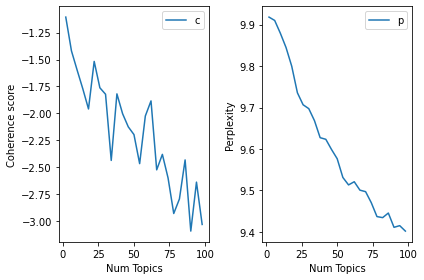

In [110]:
def compute_coherence_values(df, limit, start=2, step=3): # step : 토픽 몇 개씩 증가하면서 확인할 건지 
    """ Compute c_v coherence for various number of topics Parameters: ---------- dictionary : Gensim dictionary corpus : Gensim corpus texts : List of input texts limit : Max num of topics Returns: ------- model_list : List of LDA topic models coherence_values : Coherence values corresponding to the LDA model with respective number of topics """ 
    coherence_values = [] 
    model_list = [] 
    perplexity_values =[]
    for num_topics in range(start, limit, step): 
        lda = TopicModeling(df, num_topics)
        model = lda.LDA()
        lda.train(model)
        model_list.append(model) 
        coherencemodel = lda.get_coherence(model)[0]
        perplexitymodel = np.log(model.perplexity)
        
        coherence_values.append(coherencemodel)
        perplexity_values.append(perplexitymodel)
        
    return model_list, coherence_values, perplexity_values
        
def find_optimal_number_of_topics(df): 
    limit = 100; 
    start = 2; 
    step = 4; 
    model_list, coherence_values, perplexity_values = compute_coherence_values(df= df, start=start, limit=limit, step=step)
    x = range(start, limit, step) 
    plt.subplot(1, 2, 1)
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence"), loc='best') 
    
    plt.subplot(1, 2, 2)
    plt.plot(x, perplexity_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Perplexity") 
    plt.legend(("perplexity"), loc='best') 
    
    plt.tight_layout()
    plt.show() 
    
    
if __name__ == '__main__': 
    
    print('Number of unique tokens: %d' % len(model.used_vocabs)) 
    print('Number of documents: %d' % len(df_lex.index))

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # 최적의 토픽 수 찾기 
    find_optimal_number_of_topics(df_lex)

In [170]:
lda = TopicModeling(df_lex,54)
model = lda.LDA()
lda.train(model)
lda.get_coherence(model)
len(model.used_vocabs)

Training...


Num docs: 24774 , Vocab size: 63062 , Num words: 14935116
Removed top words: []
Iteration: 0	Log-likelihood: -9.808848036829854
Iteration: 100	Log-likelihood: -9.66068401019232
Iteration: 200	Log-likelihood: -9.593158436987629
Iteration: 300	Log-likelihood: -9.555355871125764
Iteration: 400	Log-likelihood: -9.531195264183964
topic 개수 :  54 | 사용된 vocab 수 :  63062 | Coherence 점수 :  -2.467086038120505 | Perplexity 점수 :  9.531195264183964


63062

In [172]:
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10) # top 10
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Topic #0	bp, company, oil, million, fund, business, money, bank, tax, economic
Topic #1	theatre, opera, ballet, dance, 020, theater, dancer, london, festival, production
Topic #2	novel, awards, actress, book, comedy, literature, drama, fiction, actors, writers
Topic #3	zealand, napoleon, italy, london, vienna, de, wellington, auckland, france, queen
Topic #4	bst, gmt, block, brexit, johnson, eu, labour, minister, uk, timeupdated
Topic #5	black, slavery, african, slave, racism, civil, confederate, law, court, negative
Topic #6	father, university, college, school, die, death, mother, student, mr, family
Topic #7	baseball, game, sports, player, league, team, sport, football, fame, hall
Topic #8	pm, 212, street, am, saturday, sunday, avenue, brooklyn, friday, 718
Topic #9	feel, think, like, thing, want, way, people, look, tell, kind
Topic #10	bauhaus, annabelle, roth, snowden, conjuring, vera, farmiga, doll, warren, kenosha
Topic #11	greece, greek, british, sculpture, athens, elgin, parthe

### 문서별 토픽 분포

In [173]:
df_lex['top_topic'] = 0
df_lex['topic_dist'] = 0
df_lex['topic_words']= 0

for i in tqdm(range(len(model.docs))) :
  
  df_lex['topic_dist'][i] = model.docs[i].get_topics(top_n=54)
  df_lex['top_topic'][i] = model.docs[i].get_topics()[0][0]
  res=model.get_topic_words(df_lex['top_topic'][i], top_n=10)
  df_lex['topic_words'][i] =', '.join(w for w, p in res)

  0%|          | 0/24774 [00:00<?, ?it/s]

/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/2682217599.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lex['topic_dist'][i] = model.docs[i].get_topics(top_n=54)
/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/2682217599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lex['top_topic'][i] = model.docs[i].get_topics()[0][0]
/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/2682217599.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [174]:
df_lex.to_pickle('./대영박물관_article_분석 결과.pickle')

In [4]:
df_lex = pd.read_pickle(('./대영박물관_article_분석 결과.pickle'))

In [175]:
topic_dist=df_lex['top_topic'].value_counts()
topic_dist = pd.DataFrame(topic_dist)
topic_dist

,top_topic
9,2295
0,1365
26,1041
11,1027
39,980
34,945
27,924
5,648
29,647
36,618


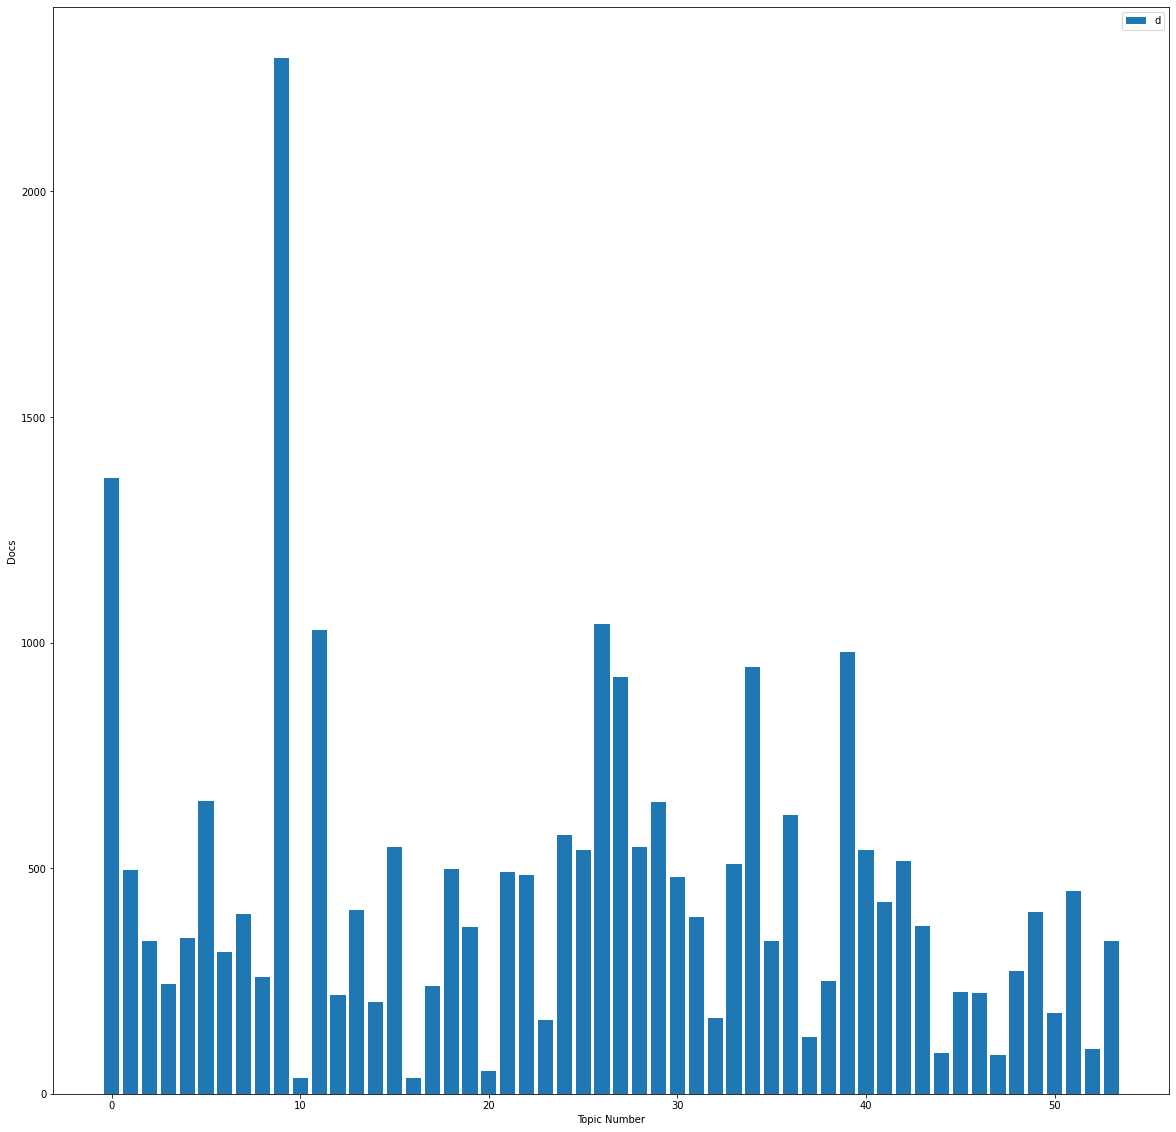

In [176]:
plt.bar(topic_dist.index, topic_dist['top_topic']) 
plt.xlabel("Topic Number") 
plt.ylabel("Docs") 
plt.legend(("docs number"), loc='best') 
plt.rcParams['figure.figsize'] = [20, 20]


plt.show()

In [128]:
df_vocab_lex= pd.DataFrame(zip(model.vocabs, model.vocab_freq, model.vocab_df), columns= ['vocab', 'vocab_freq', 'vocab_df'])

In [131]:
df_vocab_lex.to_excel('대영박물관_Article_vocab.xlsx')

Exception ignored in: <function tqdm.__del__ at 0x7fa6ccb43790>
Traceback (most recent call last):
  File "/Users/brightcircle/miniconda3/lib/python3.9/site-packages/tqdm/std.py", line 1146, in __del__
    def __del__(self):
KeyboardInterrupt: 


In [134]:
df_lex['Newspaper'].unique().tolist()

['Los Angeles Times',
 'The Guardian',
 'Jerusalem Post',
 'The New York Times',
 'Newsday (New York)',
 'The Toronto Star',
 'Chicago Tribune',
 'Financial Times (London, England)',
 'The Independent (London)',
 'The Australian',
 'International New York Times',
 'National Post (f/k/a The Financial Post) (Canada)',
 'The Age (Melbourne, Australia)',
 'Independent.co.uk',
 'The Sunday Telegraph (London)',
 'The Sunday Times (London)',
 'The Philadelphia Inquirer',
 'The Daily Telegraph (Australia)',
 'Daily News (New York)',
 'The Washington Times',
 'DAILY MAIL (London)',
 'The New York Times Blogs',
 'The Times (London)',
 'mirror.co.uk',
 'Daily Record and Sunday Mail',
 'THE KOREA HERALD',
 'South China Morning Post',
 'The Japan News',
 'USA TODAY',
 'Australian Financial Review',
 'Detroit Free Press (Michigan)',
 'Korea Times',
 'The Herald (Glasgow)',
 'The Sun (England)',
 'The Daily Telegraph (London)',
 'The Press (Christchurch, New Zealand)',
 'thestar.com',
 'The Jerusalem

### 국가 기준 DMR

#### 각 신문사 출판 국가 리스트 - 수기로 작성

In [135]:
df_news = pd.DataFrame(df_lex['Newspaper'].unique().tolist())

In [137]:
df_news.to_excel('./대영박물관_신문사list.xlsx')

In [138]:
df_news = pd.read_excel('./대영박물관_신문사list.xlsx')

In [139]:
df_news

,Unnamed: 0,Newspaper,Country
0,0,Los Angeles Times,USA
1,1,The Guardian,UK
2,2,Jerusalem Post,Israel
3,3,The New York Times,USA
4,4,Newsday (New York),USA
...,...,...,...
78,78,The Observer(London),UK
79,79,Wish Magazine,Australia
80,80,Delicate work to restore museum objects after ...,etc.
81,81,The Guardian (London),UK


In [5]:
df_lex.head()

,Newspaper,Date,Length,Author,Headline,Article,token,top_topic,topic_dist,topic_words,Country
0,Los Angeles Times,2015-06-26,642 words,Stephen Ceasar,LOS ANGELES; Legal battle over massive emerald...,The more than six-year legal battle over the B...,"[year, legal, battle, bahia, emerald, reach, c...",30,"[(30, 0.35383737087249756), (49, 0.15144985914...","india, antiquity, steal, dealer, afghanistan, ...",USA
1,The Guardian,2015-06-26,1934 words,Keith Stuart,Hearthstone: how a game developer turned 30m p...,On the set of ITV's costume drama Mr Selfridge...,"[set, itv, costume, drama, mr, selfridge, quie...",28,"[(28, 0.2616443634033203), (7, 0.2563472986221...","internet, computer, digital, video, technology...",UK
2,The Guardian,2015-06-26,628 words,Maraithe Thomas in New York,My afternoon at the Seinfeld apartment; A new ...,Related: Seinfeld on Hulu: which episodes sho...,"[relate, seinfeld, hulu, episode, download, tu...",9,"[(9, 0.2603209316730499), (43, 0.1685303896665...","feel, think, like, thing, want, way, people, l...",UK
3,Jerusalem Post,2015-06-26,1152 words,MEITAL SHARABI,Tiberias: Israel's diamond in the rough,The Kinneret is one of the most beautiful spot...,"[kinneret, beautiful, spot, country, reason, p...",36,"[(36, 0.32701045274734497), (27, 0.16811439394...","israel, jewish, jews, jerusalem, holocaust, is...",Israel
4,Los Angeles Times,2015-06-26,1128 words,NaN,LETTERS,"He's served L.A. well Re ""Patt Morrison Asks: ...","[serve, la, patt, morrison, ask, tom, labonge,...",9,"[(9, 0.13993221521377563), (49, 0.137082636356...","feel, think, like, thing, want, way, people, l...",USA


In [142]:
df_news = df_news[['Newspaper', 'Country']]

In [150]:
df_news = df_news.set_index('Newspaper')

In [151]:
df_news

,Country
Newspaper,
Los Angeles Times,USA
The Guardian,UK
Jerusalem Post,Israel
The New York Times,USA
Newsday (New York),USA
...,...
The Observer(London),UK
Wish Magazine,Australia
Delicate work to restore museum objects after major fire,etc.


In [145]:
country_list=df_news['Country'].unique()
country_list

array(['USA', 'UK', 'Israel', 'Canada', 'Australia', 'South Korea',
       'China', 'Japan', 'New Zealand', 'Malaysia', 'Russia',
       'South Africa', 'Singapore', 'Thailand', 'Ireland', 'etc.'],
      dtype=object)

In [161]:
df_lex['Country']=0

for idx, news in tqdm(enumerate(df_lex['Newspaper'])) :
    df_lex['Country'][idx] = df_news['Country'][news]
     

0it [00:00, ?it/s]

/var/folders/q9/1ydypryj47n2g37569rqj0p80000gn/T/ipykernel_14867/540972656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lex['Country'][idx] = df_news['Country'][news]


In [162]:
df_lex

,Newspaper,Date,Length,Author,Headline,Article,token,top_topic,topic_dist,topic_words,Country
0,Los Angeles Times,2015-06-26,642 words,Stephen Ceasar,LOS ANGELES; Legal battle over massive emerald...,The more than six-year legal battle over the B...,"[year, legal, battle, bahia, emerald, reach, c...",4,"[(4, 0.47281384468078613), (34, 0.152346983551...","auction, coin, item, mr, dealer, sale, sell, c...",USA
1,The Guardian,2015-06-26,1934 words,Keith Stuart,Hearthstone: how a game developer turned 30m p...,On the set of ITV's costume drama Mr Selfridge...,"[set, itv, costume, drama, mr, selfridge, quie...",8,"[(8, 0.2922247052192688), (23, 0.2112405151128...","baseball, game, player, rogen, league, cubs, h...",UK
2,The Guardian,2015-06-26,628 words,Maraithe Thomas in New York,My afternoon at the Seinfeld apartment; A new ...,Related: Seinfeld on Hulu: which episodes sho...,"[relate, seinfeld, hulu, episode, download, tu...",7,"[(7, 0.25378450751304626), (44, 0.245114162564...","film, movie, films, documentary, television, a...",UK
3,Jerusalem Post,2015-06-26,1152 words,MEITAL SHARABI,Tiberias: Israel's diamond in the rough,The Kinneret is one of the most beautiful spot...,"[kinneret, beautiful, spot, country, reason, p...",16,"[(16, 0.3555724620819092), (54, 0.194526746869...","israel, jewish, jerusalem, jews, israeli, syna...",Israel
4,Los Angeles Times,2015-06-26,1128 words,NaN,LETTERS,"He's served L.A. well Re ""Patt Morrison Asks: ...","[serve, la, patt, morrison, ask, tom, labonge,...",26,"[(26, 0.19039195775985718), (43, 0.18838784098...","government, political, policy, issue, decision...",USA
...,...,...,...,...,...,...,...,...,...,...,...
24769,Newsday (New York),2022-06-17,503 words,The Washington Post,"NATION; Harry Gesner, 97, California architect...","The Washington Post To design a great house, C...","[washington, post, design, great, house, calif...",28,"[(28, 0.18001389503479004), (21, 0.17830580472...","beach, hotel, island, tour, travel, trip, tour...",USA
24770,The Philadelphia Inquirer,2022-06-17,1371 words,Valerie Russ STAFF WRITER,Norristown exhibit honors historian Charles Bl...,ABSTRACT His life's work was fueled by a fourt...,"[abstract, life, work, fuel, fourth, grade, te...",6,"[(6, 0.22599178552627563), (36, 0.133384764194...","mr, ms, los, angeles, american, black, african...",USA
24771,mirror.co.uk,2022-06-17,1180 words,"By, Nigel Thompson",Take a shine to golden wonders from around the...,All that glisters is not gold - Often have ...,"[glister, gold, hear, tell, students, william,...",38,"[(38, 0.32706835865974426), (19, 0.09894628822...","egypt, ancient, roman, egyptian, rome, italy, ...",UK
24772,The Philadelphia Inquirer,2022-06-17,1710 words,Mike Jensen STAFF WRITER,She helped change the game; Former Owls badmin...,ABSTRACT Former Owls badminton player was lead...,"[abstract, owls, badminton, player, lead, plai...",48,"[(48, 0.3514178991317749), (31, 0.124050624668...","sports, football, sport, game, team, player, s...",USA


In [184]:
def DMR(df) :
    global token_rate_dict
    DMR_news = tp.DMRModel(k=54,min_df=100,tw=tp.TermWeight.IDF, alpha = 0.01, seed=2021, rm_top=10)
    token_rate_dict = df[['token','Country']].to_dict('index')

    for k in tqdm(token_rate_dict.keys()):
        DMR_news.add_doc(token_rate_dict[k]['token'], str(token_rate_dict[k]['Country']))

    DMR_news.train(0)

    print('Num docs:', len(DMR_news.docs), ', Vocab size:', DMR_news.num_vocabs, ', Num words:', DMR_news.num_words)
    print('Removed top words:', DMR_news.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    for i in range(0, 500, 20):
        DMR_news.train(20)
        print('Iteration: {}\tLog-likelihood: {}'.format(i, DMR_news.ll_per_word))


    print('--------------------------------------------------------------------------')


    DMR_news.summary()
    
    print('--------------------------------------------------------------------------')

    for i in range(DMR_news.k):
        res = DMR_news.get_topic_words(i, top_n=20)
        print('Topic #{}'.format(i), end='\t')
        print(', '.join(w for w, p in res))
    

    dmr_plot2(DMR_news)

    return DMR_news

In [197]:
import seaborn as sns


def dmr_plot2(mdl):
    meta_dict = mdl.metadata_dict # 메타 데이터 종류 1개
    meta_k_arr = np.zeros((len(meta_dict), mdl.k))

    for i in range(len(meta_dict)):
        meta_k_arr[i, :] = np.exp(mdl.lambdas)[:, i] / np.exp(mdl.lambdas)[:, i].sum()

    viz_df = pd.DataFrame(meta_k_arr, columns=['Topic #{}'.format(k) for k in range(mdl.k)], index=meta_dict)
    fig1 = plt.figure(figsize=(15, 8))
    ax = plt.gca()
    assert plt.gcf() is fig1  # succeeds
    viz_df.sort_index(ascending=False).plot(kind='barh', stacked=True,
                                            colormap=ListedColormap(sns.color_palette('husl', 54)),
                                            ax=ax)  # draws to fig1 now

    #sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return viz_df

#### 침탈 관련 토픽들의 분포로만 그래프 그리기

In [205]:
test = dmr_df[['Topic #8', 'Topic #17', 'Topic #23', 'Topic #44', 'Topic #51']]
test

,Topic #8,Topic #17,Topic #23,Topic #44,Topic #51
USA,0.012655,0.009645,0.015727,0.014233,0.011027
UK,0.007595,0.003912,0.009391,0.021810,0.006050
Israel,0.004809,0.011381,0.014997,0.042706,0.007095
Canada,0.058449,0.009949,0.030557,0.010788,0.034744
Australia,0.030515,0.004397,0.023432,0.004703,0.001756
South Korea,0.021533,0.017013,0.002067,0.000970,0.028216
China,0.005574,0.013229,0.012663,0.005774,0.007176
Japan,0.021016,0.003608,0.024635,0.016949,0.006235
New Zealand,0.075428,0.001236,0.018732,0.003348,0.011615
Malaysia,0.004385,0.016824,0.008418,0.007913,0.007704


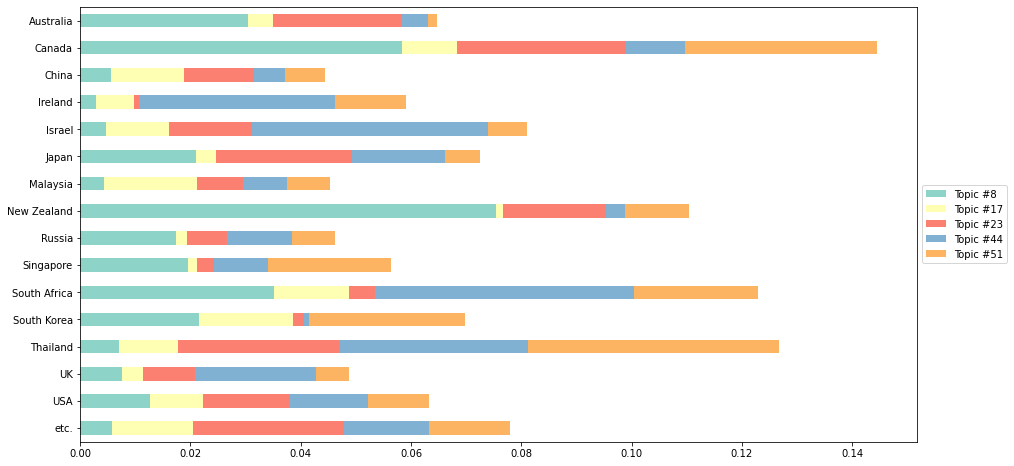

In [206]:
fig1 = plt.figure(figsize=(15, 8))
ax = plt.gca()
assert plt.gcf() is fig1  # succeeds
test.sort_index(ascending=False).plot(kind='barh', stacked=True,
                                            colormap=ListedColormap(sns.color_palette('Set3', 54)),
                                            ax=ax)  # draws to fig1 now

    #sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [201]:
dmr_df.sort_index(ascending=False).plot(kind='barh', stacked=True,
                                            colormap=ListedColormap(sns.color_palette('Set3', 54)),
                                            ax=ax)  # draws to fig1 now

NameError: name 'ax' is not defined

In [ ]:
lda = TopicModeling(df_lex,54)
model = lda.LDA()
lda.train(model)
lda.get_coherence(model)
len(model.used_vocabs)

In [6]:
class TopicModeling :
    
    def __init__(self, df, k, min_df=100 ) : #df = 데이터, k은 토픽 개수, min_df =10
        self.df = df
        self.k = k
        self.min_df= min_df
    
    
            
    def LDA(self) :
        
        LDA_model = tp.LDAModel(k= self.k, min_df=self.min_df, tw= tp.TermWeight.IDF, rm_top=0, alpha=0.01, seed=2021 )
        for token in self.df['token'].tolist():
            LDA_model.add_doc(token)

        return LDA_model
       
    def DMR(self) :
        global token_rate_dict
        LDA_model = tp.DMRModel(k=54,min_df=100,tw=tp.TermWeight.IDF, alpha = 0.01, seed=2021, rm_top=10)
        token_rate_dict = self.df[['token','Country']].to_dict('index')

        for k in tqdm(token_rate_dict.keys()):
            LDA_model.add_doc(token_rate_dict[k]['token'], str(token_rate_dict[k]['Country']))

        return LDA_model
        
    def train(self, LDA_model) :
        LDA_model.train(0)
        print('Num docs:', len(LDA_model.docs), ', Vocab size:', LDA_model.num_vocabs, ', Num words:', LDA_model.num_words)
        print('Removed top words:', LDA_model.removed_top_words) #확인
        print('Training...', file=sys.stderr, flush=True)
        for i in range(0, 500, 100):
            LDA_model.train(100)
            print('Iteration: {}\tLog-likelihood: {}'.format(i, LDA_model.ll_per_word))
            
    def get_coherence(self, LDA_model) :
        coherence = tp.coherence
        score = coherence.Coherence(LDA_model).get_score()
        perplexity = LDA_model.perplexity
        print('topic 개수 : ', self.k , '| 사용된 vocab 수 : ',len(LDA_model.used_vocabs) ,'| Coherence 점수 : ', score, '| Perplexity 점수 : ', np.log(perplexity))
    

        return score, perplexity

In [15]:
dmr = TopicModeling(df_lex, 54)
model = dmr.DMR()
dmr.train(model)
dmr.get_coherence(model)
len(model.used_vocabs)

  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.109033438021386
Iteration: 100	Log-likelihood: -8.997246550971699
Iteration: 200	Log-likelihood: -8.951817100179312


KeyboardInterrupt: 

  0%|          | 0/24774 [00:00<?, ?it/s]

Number of unique tokens: 0
Number of documents: 24774


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.11666468797557
Iteration: 100	Log-likelihood: -8.99821800669378
Iteration: 200	Log-likelihood: -8.955437986284867
Iteration: 300	Log-likelihood: -8.929201245222691
Iteration: 400	Log-likelihood: -8.908753008812303
topic 개수 :  2 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5779686612819015 | Perplexity 점수 :  8.908753008812303


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.129898674831933
Iteration: 100	Log-likelihood: -9.00434422211432
Iteration: 200	Log-likelihood: -8.961715152124173
Iteration: 300	Log-likelihood: -8.929756391446
Iteration: 400	Log-likelihood: -8.917548587345198
topic 개수 :  6 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6213524730271824 | Perplexity 점수 :  8.917548587345198


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.112008156752982
Iteration: 100	Log-likelihood: -8.997109939821758
Iteration: 200	Log-likelihood: -8.95211371523779
Iteration: 300	Log-likelihood: -8.935926376441623
Iteration: 400	Log-likelihood: -8.912179783916237
topic 개수 :  10 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5693966083557573 | Perplexity 점수 :  8.912179783916237


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.118910813667371
Iteration: 100	Log-likelihood: -8.998486364691127
Iteration: 200	Log-likelihood: -8.953652358943065
Iteration: 300	Log-likelihood: -8.931170810756642
Iteration: 400	Log-likelihood: -8.91147689200945
topic 개수 :  14 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.592318413685254 | Perplexity 점수 :  8.91147689200945


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.110660512092968
Iteration: 100	Log-likelihood: -8.997755245846413
Iteration: 200	Log-likelihood: -8.947364603566482
Iteration: 300	Log-likelihood: -8.934942184561786
Iteration: 400	Log-likelihood: -8.911129937155659
topic 개수 :  18 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6346084136209518 | Perplexity 점수 :  8.911129937155659


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.10393156928771
Iteration: 100	Log-likelihood: -8.998239313625962
Iteration: 200	Log-likelihood: -8.95204090929563
Iteration: 300	Log-likelihood: -8.92492064132601
Iteration: 400	Log-likelihood: -8.909793369741177
topic 개수 :  22 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5915138497346983 | Perplexity 점수 :  8.909793369741177


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.121933975910329
Iteration: 100	Log-likelihood: -9.003939021072222
Iteration: 200	Log-likelihood: -8.954584182574514
Iteration: 300	Log-likelihood: -8.929729406961028
Iteration: 400	Log-likelihood: -8.913108307038659
topic 개수 :  26 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5627592980819838 | Perplexity 점수 :  8.913108307038659


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.10808879238827
Iteration: 100	Log-likelihood: -8.995795072009228
Iteration: 200	Log-likelihood: -8.95377863038786
Iteration: 300	Log-likelihood: -8.929428633225555
Iteration: 400	Log-likelihood: -8.91457680833876
topic 개수 :  30 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5963080906640104 | Perplexity 점수 :  8.91457680833876


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.115876698119134
Iteration: 100	Log-likelihood: -9.004199959567803
Iteration: 200	Log-likelihood: -8.955115940662878
Iteration: 300	Log-likelihood: -8.932680724019917
Iteration: 400	Log-likelihood: -8.914594541079408
topic 개수 :  34 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5985856035269377 | Perplexity 점수 :  8.914594541079408


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.116545426831811
Iteration: 100	Log-likelihood: -9.002198853321945
Iteration: 200	Log-likelihood: -8.956308483848794
Iteration: 300	Log-likelihood: -8.923944084635089
Iteration: 400	Log-likelihood: -8.91222199473356
topic 개수 :  38 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5955227689915166 | Perplexity 점수 :  8.91222199473356


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.117846923743118
Iteration: 100	Log-likelihood: -9.000766169913831
Iteration: 200	Log-likelihood: -8.950818713776187
Iteration: 300	Log-likelihood: -8.92373109221175
Iteration: 400	Log-likelihood: -8.909092279040044
topic 개수 :  42 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6108271539906232 | Perplexity 점수 :  8.909092279040044


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.119802686306237
Iteration: 100	Log-likelihood: -9.003719665058581
Iteration: 200	Log-likelihood: -8.95235410895079
Iteration: 300	Log-likelihood: -8.927632655235897
Iteration: 400	Log-likelihood: -8.90787368246774
topic 개수 :  46 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5890245039700914 | Perplexity 점수 :  8.90787368246774


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.119319485375193
Iteration: 100	Log-likelihood: -8.99546263302519
Iteration: 200	Log-likelihood: -8.950537518722166
Iteration: 300	Log-likelihood: -8.923361566750605
Iteration: 400	Log-likelihood: -8.901546769869084
topic 개수 :  50 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.590630383663324 | Perplexity 점수 :  8.901546769869084


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.108617667384884
Iteration: 100	Log-likelihood: -8.999514384602387
Iteration: 200	Log-likelihood: -8.961607912191646
Iteration: 300	Log-likelihood: -8.925237484158082
Iteration: 400	Log-likelihood: -8.909892677590289
topic 개수 :  54 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6082319583782845 | Perplexity 점수 :  8.909892677590289


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.11286428278741
Iteration: 100	Log-likelihood: -8.995348959187522
Iteration: 200	Log-likelihood: -8.946250706812286
Iteration: 300	Log-likelihood: -8.926044204498957
Iteration: 400	Log-likelihood: -8.908343032651965
topic 개수 :  58 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5756769356299234 | Perplexity 점수 :  8.908343032651965


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.119542531942697
Iteration: 100	Log-likelihood: -9.003679558927473
Iteration: 200	Log-likelihood: -8.954050828107006
Iteration: 300	Log-likelihood: -8.928689657124279
Iteration: 400	Log-likelihood: -8.911582034411037
topic 개수 :  62 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5290467217204915 | Perplexity 점수 :  8.911582034411037


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.104991057980087
Iteration: 100	Log-likelihood: -9.000391318315687
Iteration: 200	Log-likelihood: -8.955399376918496
Iteration: 300	Log-likelihood: -8.922103428348379
Iteration: 400	Log-likelihood: -8.903648240970497
topic 개수 :  66 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5676065589834125 | Perplexity 점수 :  8.903648240970497


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.11280160314972
Iteration: 100	Log-likelihood: -8.999415263822002
Iteration: 200	Log-likelihood: -8.955975313857573
Iteration: 300	Log-likelihood: -8.92820375462843
Iteration: 400	Log-likelihood: -8.91778875342862
topic 개수 :  70 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5742424192434101 | Perplexity 점수 :  8.91778875342862


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.126096149955735
Iteration: 100	Log-likelihood: -8.996893206947723
Iteration: 200	Log-likelihood: -8.947325404509611
Iteration: 300	Log-likelihood: -8.920997735078917
Iteration: 400	Log-likelihood: -8.899133399199227
topic 개수 :  74 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.606238632414936 | Perplexity 점수 :  8.899133399199227


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.112190001356163
Iteration: 100	Log-likelihood: -9.001332877500063
Iteration: 200	Log-likelihood: -8.950844560745143
Iteration: 300	Log-likelihood: -8.927694086604843
Iteration: 400	Log-likelihood: -8.91136281123678
topic 개수 :  78 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6531559321476634 | Perplexity 점수 :  8.91136281123678


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.106143685700776
Iteration: 100	Log-likelihood: -8.994876958670575
Iteration: 200	Log-likelihood: -8.956884960919592
Iteration: 300	Log-likelihood: -8.935308571321404
Iteration: 400	Log-likelihood: -8.910310243614243
topic 개수 :  82 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6006655822194562 | Perplexity 점수 :  8.910310243614243


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.124359885967179
Iteration: 100	Log-likelihood: -9.006477778559791
Iteration: 200	Log-likelihood: -8.954371521956958
Iteration: 300	Log-likelihood: -8.929641312376946
Iteration: 400	Log-likelihood: -8.913591853181316
topic 개수 :  86 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5853431782291552 | Perplexity 점수 :  8.913591853181316


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.120406046745565
Iteration: 100	Log-likelihood: -9.005322529338345
Iteration: 200	Log-likelihood: -8.960992462017623
Iteration: 300	Log-likelihood: -8.936244855372665
Iteration: 400	Log-likelihood: -8.90815401267573
topic 개수 :  90 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6511327591236733 | Perplexity 점수 :  8.90815401267573


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.124507613184036
Iteration: 100	Log-likelihood: -9.009445776969518
Iteration: 200	Log-likelihood: -8.94720387322568
Iteration: 300	Log-likelihood: -8.920152238278408
Iteration: 400	Log-likelihood: -8.900137472688664
topic 개수 :  94 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.6132736444344142 | Perplexity 점수 :  8.900137472688664


  0%|          | 0/24774 [00:00<?, ?it/s]

Training...


Num docs: 24774 , Vocab size: 10927 , Num words: 12726897
Removed top words: ['museum', '90', 'year', '78', 'new', 'art', 'work', '89', 'time', 'like']
Iteration: 0	Log-likelihood: -9.12007977219232
Iteration: 100	Log-likelihood: -9.003165452196786
Iteration: 200	Log-likelihood: -8.956752123819145
Iteration: 300	Log-likelihood: -8.928881614934589
Iteration: 400	Log-likelihood: -8.91292015247781
topic 개수 :  98 | 사용된 vocab 수 :  10927 | Coherence 점수 :  -1.5629259090424799 | Perplexity 점수 :  8.91292015247781


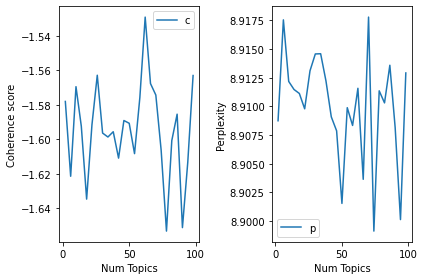

In [16]:
def compute_coherence_values(df, limit, start=2, step=3): # step : 토픽 몇 개씩 증가하면서 확인할 건지 
    """ Compute c_v coherence for various number of topics Parameters: ---------- dictionary : Gensim dictionary corpus : Gensim corpus texts : List of input texts limit : Max num of topics Returns: ------- model_list : List of LDA topic models coherence_values : Coherence values corresponding to the LDA model with respective number of topics """ 
    coherence_values = [] 
    model_list = [] 
    perplexity_values =[]
    for num_topics in range(start, limit, step): 
        lda = TopicModeling(df, num_topics)
        model = lda.DMR()
        lda.train(model)
        model_list.append(model) 
        coherencemodel = lda.get_coherence(model)[0]
        perplexitymodel = np.log(model.perplexity)
        
        coherence_values.append(coherencemodel)
        perplexity_values.append(perplexitymodel)
        
    return model_list, coherence_values, perplexity_values
        
def find_optimal_number_of_topics(df): 
    limit = 100; 
    start = 2; 
    step = 4; 
    model_list, coherence_values, perplexity_values = compute_coherence_values(df= df, start=start, limit=limit, step=step)
    x = range(start, limit, step) 
    plt.subplot(1, 2, 1)
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence"), loc='best') 
    
    plt.subplot(1, 2, 2)
    plt.plot(x, perplexity_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Perplexity") 
    plt.legend(("perplexity"), loc='best') 
    
    plt.tight_layout()
    plt.show() 
    
    
if __name__ == '__main__': 
    
    dmr = TopicModeling(df_lex, 54)
    model = dmr.DMR()
    print('Number of unique tokens: %d' % len(model.used_vocabs)) 
    print('Number of documents: %d' % len(df_lex.index))

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # 최적의 토픽 수 찾기 
    
    find_optimal_number_of_topics(df_lex)